<a href="https://colab.research.google.com/github/stanislavfort/ensemble-everything-everywhere/blob/main/quick_replication_for_multi_resolution_self_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble everything everywhere: Multi-scale aggregation for adversarial robustness

# This Colab trains and experiments with a multi-resolution self-ensemble (see and https://arxiv.org/abs/2408.05446 and https://stanislavfort.com/ensemble-everything/ for more details)
This code reproduces a multi-resolution self-ensemble network from the paper *Ensemble everything everywhere: Multi-scale aggregation for adversarial robustness* (https://arxiv.org/abs/2408.05446) by Stanislav Fort (https://scholar.google.com/citations?user=eu2Kzn0AAAAJ) and Balaji Lakshminarayanan (https://scholar.google.com/citations?user=QYn8RbgAAAAJ).

We start from an Imagenet-pretrained ResNet152, replace its first and last layers, make it ready to use multi-resolution inputs generated from a single image, and finetune on CIFAR-100.

We then train separate linear layers for each of the intermediate representations on top of a frozen backbone model. From these, we form a self-ensemble. We evalaute its adversarial accuracy on CIFAR-100 using the RobustBench AutoAttack at the end (with the `rand` flag enable).

The whole Colab should take ~60 minutes on an A100 GPU and should be self-contained. It should give you above/about SOTA adversarial robustness on CIFAR-100 under $L_\infty = 8/255$ attacks already, visualize the successfully attacked images and also visualize the class prototypes optimized directly from pixels

You will be able to visualize successful attacks on the multi-resolution model you train and see that it model is so robust that it effectively becomes a generator.

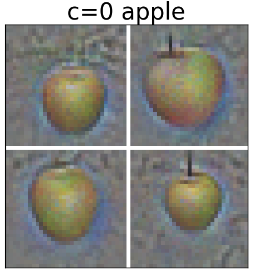

You will also see when the AutoAttack do succeed in breaking the model, the change happens in a very interpretable way, like here, where a *rocket* gets misclassified as a *cloud*

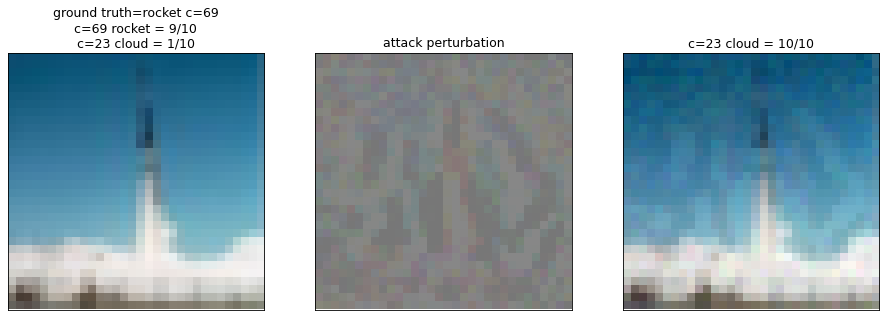

In [1]:
# make sure you get an A100 for a fast reproduction
!nvidia-smi

Mon Oct 14 12:59:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              40W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

# Imports

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

import random
import hashlib
import time
import copy

import matplotlib.pyplot as plt

from contextlib import contextmanager
from tqdm import tqdm

# Utils

Using an environment to separate random-seed-fixing behavior from the adversarial attack evaluation later

In [3]:
@contextmanager
def isolated_environment():
    # Save the current state of random seeds and numpy precision
    np_random_state = np.random.get_state()
    python_random_state = random.getstate()
    torch_random_state = torch.get_rng_state()
    cuda_random_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    numpy_print_options = np.get_printoptions()
    try:
        # Execute the block of code
        yield
    finally:
        # Restore the saved state
        np.random.set_state(np_random_state)
        random.setstate(python_random_state)
        torch.set_rng_state(torch_random_state)
        if cuda_random_state:
            torch.cuda.set_rng_state_all(cuda_random_state)
        np.set_printoptions(**numpy_print_options)


# Dataset (CIFAR-100 by default)

Getting CIFAR-100

In [4]:
classes = 100
assert classes == 100

if classes == 10:
  # Load the CIFAR-10 dataset
  trainset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True,
  )
  testset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True)

  original_images_train_np = np.array(trainset.data)
  original_labels_train_np = np.array(trainset.targets)

  original_images_test_np = np.array(testset.data)
  original_labels_test_np = np.array(testset.targets)

elif classes == 100:
  # Load the CIFAR-100 dataset
  trainset = torchvision.datasets.CIFAR100(
      root='./data', train=True, download=True,
  )
  testset = torchvision.datasets.CIFAR100(
      root='./data', train=False, download=True)

  original_images_train_np = np.array(trainset.data)
  original_labels_train_np = np.array(trainset.targets)

  original_images_test_np = np.array(testset.data)
  original_labels_test_np = np.array(testset.targets)

else:
  # assert False
  # Load the MNIST dataset
  trainset = torchvision.datasets.MNIST(
      root='./data', train=True, download=True,
  )
  testset = torchvision.datasets.MNIST(
      root='./data', train=False, download=True)

  original_images_train_np = np.array(trainset.data)
  original_labels_train_np = np.array(trainset.targets)

  original_images_train_np = np.stack([original_images_train_np]*3,axis=3)

  original_images_test_np = np.array(testset.data)
  original_labels_test_np = np.array(testset.targets)

  original_images_test_np = np.stack([original_images_test_np]*3,axis=3)

  classes = 10


100%|██████████| 169001437/169001437 [00:01<00:00, 87674410.83it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
#images between 0 and 1 instead of 0 and 255

images_train_np = original_images_train_np/255.0
images_test_np = original_images_test_np/255.0

labels_train_np = original_labels_train_np
labels_test_np = original_labels_test_np

# Multi-resolution generator

In [6]:
# to be able to replace the random number generator by other things if needed
def custom_rand(input_tensor, size):
    return torch.Tensor(
        np.random.rand(*size)
    ).to("cuda")

def custom_choices(items, tensor):
  return np.random.choice(items,(len(tensor)))

## Image augmentations

In [7]:
# apply image augmentations to input images
def apply_transformations(
    images,
    down_res = 224,
    up_res = 224,
    jit_x = 0,
    jit_y = 0,
    down_noise = 0.0,
    up_noise = 0.0,
    contrast = 1.0,
    color_amount = 1.0,
    ):

  # # for MNIST alone
  # images = torch.mean(images,axis=1,keepdims=True)

  images_collected = []

  for i in range(images.shape[0]):

    image = images[i]

    # changing contrast
    image = torchvision.transforms.functional.adjust_contrast(image, contrast[i])

    # shift the result in x and y
    image = torch.roll(image,shifts=(jit_x[i], jit_y[i]),dims=(-2,-1))

    # shifting in the color <-> grayscale axis
    image = color_amount[i]*image + torch.mean(image,axis=0,keepdims=True)*(1-color_amount[i])

    images_collected.append(image)

  images = torch.stack(images_collected, axis=0)

  # descrease the resolution
  images = F.interpolate(images, size=(down_res,down_res), mode='bicubic')

  # low res noise
  noise = down_noise * custom_rand(images+312, (images.shape[0],3,down_res,down_res)).to("cuda")
  images = images + noise

  # increase the resolution
  images = F.interpolate(images, size=(up_res,up_res), mode='bicubic')

  # high res noise
  noise = up_noise * custom_rand(images+812,(images.shape[0],3,up_res,up_res)).to("cuda")
  images = images + noise

  # clipping to the right range of values
  images = torch.clip(images,0,1)

  return images

## Making the multi-resolution channel-wise image stack

In [8]:
resolutions = [32,16,8,4] # pretty arbitrary
down_noise = 0.2 # noise standard deviation to be added at the low resolution
up_noise = 0.2 # noise stadard deviation to be added at the high resolution
jit_size = 3 # max size of the x-y jit in each axis, sampled uniformly from -jit_size to +jit_size inclusive

# to shuffle randomly which image is which in the multi-res stack
# False for all experiments in the paper, good for ablations
shuffle_image_versions_randomly = False


def default_make_multichannel_input(images):
  return torch.concatenate([images]*len(resolutions),axis=1)

def make_multichannel_input(images,
                            contrast = 1.0,
                            up_res = 32, # hard coded for CIFAR-10 or CIFAR-100
                            ):

  all_channels = []

  for i,r in enumerate(resolutions):

    down_res = r

    jits_x = custom_choices(range(-jit_size,jit_size+1), images+i) # x-shift
    jits_y = custom_choices(range(-jit_size,jit_size+1), 51*images+7*i+125*r) # y-shift
    contrasts = custom_choices(np.linspace(0.7,1.5,100), 7+3*images+9*i+5*r) # change in contrast
    color_amounts = contrasts = custom_choices(np.linspace(0.5,1.0,100), 5+7*images+8*i+2*r) # change in color amount

    images_now = apply_transformations(
      images,
      down_res = down_res,
      up_res = up_res,
      jit_x = jits_x,
      jit_y = jits_y,
      down_noise = down_noise,
      up_noise = up_noise,
      contrast = contrasts,
      color_amount = color_amounts,
      )

    all_channels.append(images_now)

  if not shuffle_image_versions_randomly:
    return torch.concatenate(all_channels,axis=1)
  elif shuffle_image_versions_randomly:
    indices = torch.randperm(len(all_channels))
    shuffled_tensor_list = [all_channels[i] for i in indices]
    return torch.concatenate(shuffled_tensor_list,axis=1)

## Testing the multi-resolution generator

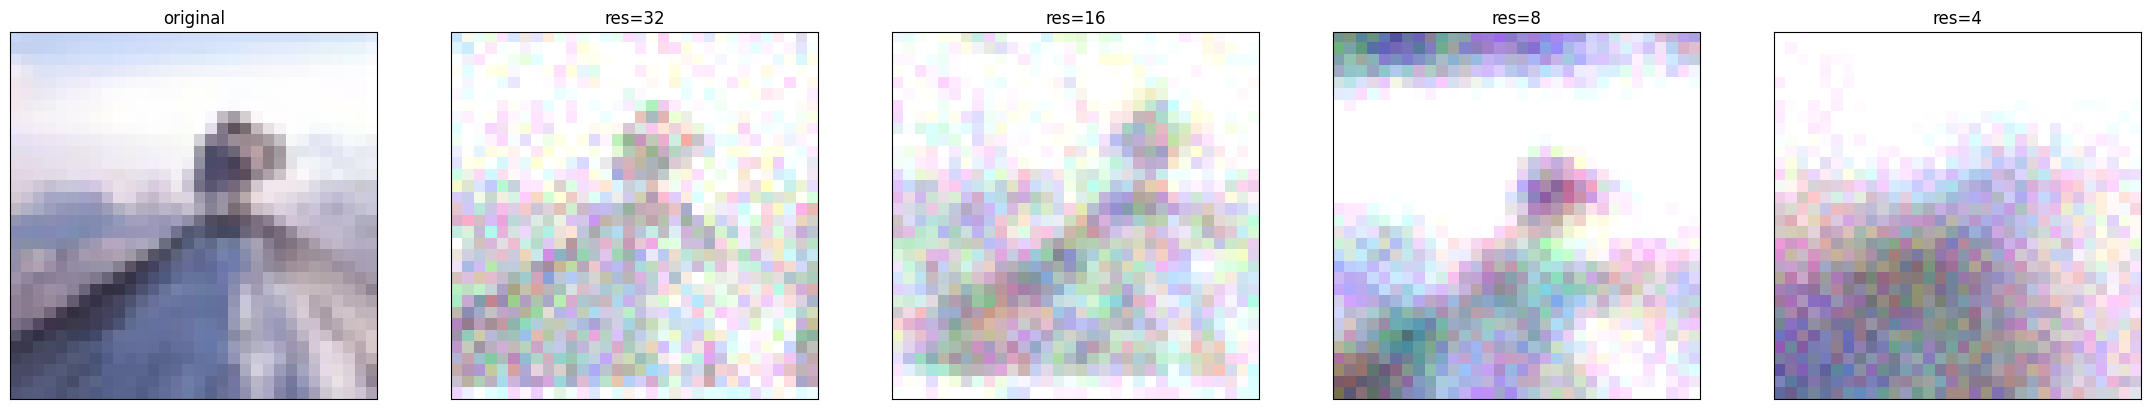

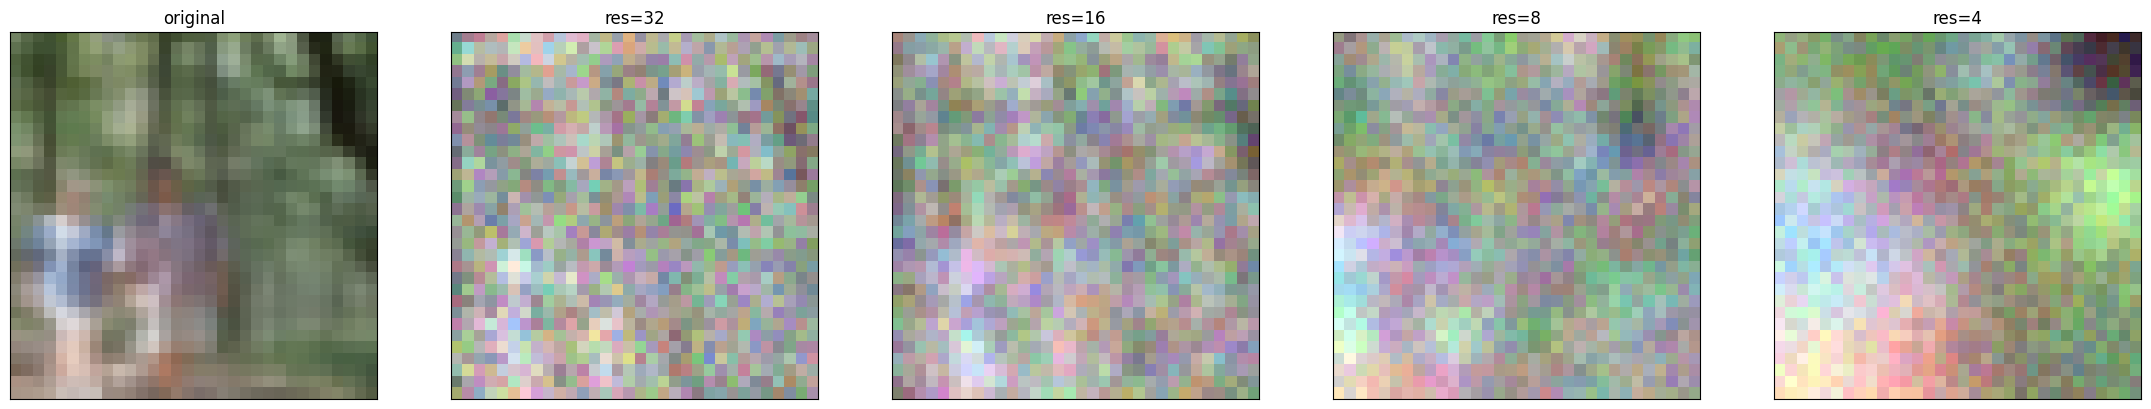

In [9]:
sample_images = images_test_np[:5]

for j in [0,1]:
  multichannel_images = make_multichannel_input(
      torch.Tensor(sample_images.transpose([0,3,1,2])).to("cuda"),
  ).detach().cpu().numpy().transpose([0,2,3,1])

  N = 1 + multichannel_images.shape[3] // 3

  plt.figure(figsize=(N*5.5,5))

  plt.subplot(1,N,1)
  plt.title("original")
  plt.imshow(sample_images[j])
  plt.xticks([],[])
  plt.yticks([],[])

  for i in range(N-1):
    plt.subplot(1,N,i+2)
    plt.title(f"res={resolutions[i]}")
    plt.imshow(multichannel_images[j,:,:,3*i:3*(i+1)])
    plt.xticks([],[])
    plt.yticks([],[])

  plt.show()

# Backbone model

## Eval tooling

In [10]:
def eval_model(model,images_in,labels_in,batch_size=128):
  all_preds = []
  all_logits = []

  with torch.no_grad():
    its = int(np.ceil(float(len(images_in))/float(batch_size)))

    pbar = tqdm(range(its), desc='Eval', ncols=100)

    for it in pbar:
      i1 = it*batch_size
      i2 = min([(it+1)*batch_size, len(images_in)])

      inputs = torch.Tensor(images_in[i1:i2].transpose([0,3,1,2])).to("cuda")
      outputs = model(inputs)

      all_logits.append(outputs.detach().cpu().numpy())

      preds = torch.argmax(outputs,axis=-1)
      all_preds.append(preds.detach().cpu().numpy())

  all_preds = np.concatenate(all_preds,axis=0)
  all_logits = np.concatenate(all_logits,axis=0)

  return np.sum(all_preds == labels_in), all_preds.shape[0], all_logits

## Getting pretrained model

In [11]:
from torchvision.models import resnet152, ResNet152_Weights

imported_model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 201MB/s]


## New first conv layer for multi-res

In [12]:
# fixed for ResNet152 first conv layer, change for others by hand
in_planes = 3
planes = 64
stride = 2
N = len(resolutions)  # input channels multiplier due to multi-res input

conv2 = nn.Conv2d(N * in_planes, planes, kernel_size=7, stride=stride, padding=3, bias=False)

In [13]:
# replacing the pretrained conv with new init of the multi-res one
imported_model.conv1 = copy.deepcopy(conv2)

## New final layer to predict classes

In [14]:
# getting the final layer to predcit the right number of classes -> new init
imported_model.fc = nn.Linear(2048, classes)

## Multi-res wrapper to interface with ResNet152

In [15]:
class ImportedModelWrapper(nn.Module):
  def __init__(self, imported_model, multichannel_fn):
    super(ImportedModelWrapper, self).__init__()
    self.imported_model = imported_model
    self.multichannel_fn = multichannel_fn

  def forward(self,x):
    x = self.multichannel_fn(x)
    x = F.interpolate(x, size=(224,224), mode='bicubic')
    x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406]*(x.shape[1]//3), std=[0.229, 0.224, 0.225]*(x.shape[1]//3))(x)
    x = self.imported_model(x)
    return x

In [16]:
wrapped_model = ImportedModelWrapper(imported_model, make_multichannel_input).to("cuda")
wrapped_model.multichannel_fn = make_multichannel_input

# Backbone training

## Training utils

In [17]:
# to get light adversarial training going, off by default
def fgsm_attack(model, xs, ys, epsilon, random_reps=1, batch_size=64):

    model = model.eval()

    its = int(np.ceil(xs.shape[0]/batch_size))

    all_perturbed_images = []

    for it in range(its):
      i1 = it*batch_size
      i2 = min([(it+1)*batch_size,xs.shape[0]])

      x = torch.Tensor(xs[i1:i2].transpose([0,3,1,2])).to("cuda")
      y = torch.Tensor(ys[i1:i2]).to("cuda").to(torch.long)

      x.requires_grad = True

      for _ in range(random_reps):
        outputs = model(x)
        loss = nn.CrossEntropyLoss()(outputs, y)
        loss.backward()

      perturbed_image = x + epsilon * x.grad.data.sign()
      perturbed_image = torch.clip(perturbed_image, 0, 1)

      all_perturbed_images.append(perturbed_image.detach().cpu().numpy().transpose([0,2,3,1]))

    return np.concatenate(all_perturbed_images,axis=0)

In [18]:
def train_model(
    model_in,
    images_in,
    labels_in,
    epochs = 10,
    lr=1e-3,
    batch_size = 512,
    optimizer_in = optim.Adam,
    subset_only = None,
    mode = "eval",
    use_adversarial_training = False,
    adversarial_epsilon = 8/255,
    skip_test_set_eval = False,
  ):

  global storing_models

  if mode == "train":
    model_in.train()
  elif mode == "eval":
    model_in.eval()

  criterion = nn.CrossEntropyLoss()

  if subset_only is None:
    train_optimizer = optimizer_in(model_in.parameters(), lr=lr)
  else:
    train_optimizer = optimizer_in(subset_only, lr=lr)


  for epoch in range(epochs):

    randomized_ids = np.random.permutation(range(len(images_in)))

    # making sure the model is in the right eval/train mode every epoch
    # due to the potential switching by black-box evals applied
    if mode == "train":
      model_in.train()
    elif mode == "eval":
      model_in.eval()
    else:
      assert False

    its = int(np.ceil(float(len(images_in))/float(batch_size)))
    pbar = tqdm(range(its), desc='Training', ncols=100)

    all_hits = []

    for it in pbar:

      i1 = it*batch_size
      i2 = min([(it+1)*batch_size, len(images_in)])

      ids_now = randomized_ids[i1:i2]

      np_images_used = images_in[ids_now]
      np_labels_used = labels_in[ids_now]

      inputs = torch.Tensor(np_images_used.transpose([0,3,1,2])).to("cuda")

      # very light adversarial training if on
      if use_adversarial_training:
        attacked_images = fgsm_attack(
            model_in.eval(),
            np_images_used[:],
            np_labels_used[:],
            epsilon=adversarial_epsilon,
            random_reps=1,
            batch_size=batch_size//2,
            )
        np_images_used = attacked_images
        np_labels_used = np_labels_used

        if mode == "train":
          model_in.train()
        elif mode == "eval":
          model_in.eval()

      inputs = torch.Tensor(np_images_used.transpose([0,3,1,2])).to("cuda")
      labels = torch.Tensor(np_labels_used).to("cuda").to(torch.long)

      # zero the parameter gradients
      train_optimizer.zero_grad()

      inputs_used = inputs

      # the actual optimization step
      outputs = model_in(inputs_used)
      loss = criterion(outputs, labels)
      loss.backward()
      train_optimizer.step()

      # on the fly eval for the train set batches
      preds = torch.argmax(outputs,axis=-1)
      acc = torch.mean((preds == labels).to(torch.float),axis=-1)
      all_hits.append((preds == labels).to(torch.float).detach().cpu().numpy())
      train_accs.append(acc.detach().cpu().numpy())

      pbar.set_description(f"train acc={acc.detach().cpu().numpy()} loss={loss.item()}")


    if not skip_test_set_eval:
      with isolated_environment():
        eval_model_copy = copy.deepcopy(model_in)
        test_hits,test_count,_ = eval_model(eval_model_copy.eval(), images_test_np, labels_test_np)
    else:
      # to avoid dividing by zero
      test_hits = 0
      test_count = 1

    # end of epoch eval
    train_hits = np.sum(np.concatenate(all_hits,axis=0).reshape([-1]))
    train_count = np.concatenate(all_hits,axis=0).reshape([-1]).shape[0]
    print(f"e={epoch} train {train_hits} / {train_count} = {train_hits/train_count},  test {test_hits} / {test_count} = {test_hits/test_count}")

    test_accs.append(test_hits/test_count)

  print('\nFinished Training')

  return model_in

## Training the backbone (takes 20 mins on A100 for 6 epochs)

In [19]:
lr=3.3e-5 # found with very simple "grid search" by hand, likely not optimal!
mode = "train"

epochs = 6

model = copy.deepcopy(wrapped_model)
model.multichannel_fn = make_multichannel_input

if mode == "eval":
  model = model.eval()
elif mode == "train":
  model = model.train()
else:
  assert False

train_accs = []
test_accs = []

In [20]:
torch.cuda.empty_cache()

device = torch.device("cuda:0")

# with torch.autocast("cuda"):
model = train_model(
    model,
    images_train_np,
    labels_train_np,
    epochs=epochs,
    lr=lr,
    optimizer_in = optim.Adam,
    batch_size=128,
    mode=mode,
    )

train acc=0.11250000447034836 loss=3.721997022628784: 100%|███████| 391/391 [03:12<00:00,  2.03it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.84it/s]


e=0 train 3112.0 / 50000 = 0.06224,  test 1426 / 10000 = 0.1426


train acc=0.42500001192092896 loss=2.5146312713623047: 100%|██████| 391/391 [03:09<00:00,  2.06it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.80it/s]


e=1 train 11141.0 / 50000 = 0.22282,  test 3121 / 10000 = 0.3121


train acc=0.45000001788139343 loss=2.036752939224243: 100%|███████| 391/391 [03:10<00:00,  2.06it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.82it/s]


e=2 train 19405.0 / 50000 = 0.3881,  test 4427 / 10000 = 0.4427


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.82it/s]


e=3 train 24968.0 / 50000 = 0.49936,  test 5199 / 10000 = 0.5199


train acc=0.5875000357627869 loss=1.3128316402435303: 100%|███████| 391/391 [03:09<00:00,  2.06it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.83it/s]


e=4 train 28510.0 / 50000 = 0.5702,  test 5707 / 10000 = 0.5707


train acc=0.6000000238418579 loss=1.5039019584655762: 100%|███████| 391/391 [03:09<00:00,  2.06it/s]
Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.83it/s]

e=5 train 31156.0 / 50000 = 0.62312,  test 6049 / 10000 = 0.6049

Finished Training


# Self-ensemble

## Getting intermediate layer read outs

In [21]:
class BatchNormLinear(nn.Module):
    def __init__(self, in_features, out_features, device='cuda'):
        super(BatchNormLinear, self).__init__()
        self.batch_norm = nn.BatchNorm1d(in_features, device=device)
        self.linear = nn.Linear(in_features, out_features, device=device)

    def forward(self, x):
        x = self.batch_norm(x)
        return self.linear(x)

class WrapModelForResNet152(torch.nn.Module):

  def __init__(self, model, multichannel_fn, classes=10):
    super(WrapModelForResNet152, self).__init__()

    self.multichannel_fn = multichannel_fn

    self.model = model

    self.classes = classes

    self.layer_operations = [
      torch.nn.Sequential(
          model.conv1,
          model.bn1,
          model.relu,
          model.maxpool,
      ),
      *model.layer1,
      *model.layer2,
      *model.layer3,
      *model.layer4,
      model.avgpool,
      model.fc,
    ]

    self.all_dims = [
      3*224*224*len(resolutions),
      64*56*56,
      *[256*56*56]*len(model.layer1),
      *[512*28*28]*len(model.layer2),
      *[1024*14*14]*len(model.layer3),
      *[2048*7*7]*len(model.layer4),
      2048,
      1000,
    ]

    self.linear_layers = torch.nn.ModuleList([
      BatchNormLinear(self.all_dims[i], classes, device="cuda") for i in range(len(self.all_dims))
    ])

  def prepare_input(self, x):
    x = self.multichannel_fn(x)
    x = F.interpolate(x, size=(224,224), mode='bicubic')
    x = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406]*(x.shape[1]//3), std=[0.229, 0.224, 0.225]*(x.shape[1]//3))(x)
    return x


  def forward_until(self, x, layer_id):

    x = self.prepare_input(x)

    for l in range(layer_id):

      if list(x.shape)[1:] == [2048,1,1]:
        x = x.reshape([-1,2048])

      x = self.layer_operations[l](x)
    return x

  def forward_after(self, x, layer_id):

    x = self.prepare_input(x)

    for l in range(layer_id,len(self.layer_operations)):

      if list(x.shape)[1:] == [2048,1,1]:
        x = x.reshape([-1,2048])

      x = self.layer_operations[l](x)
    return x

  def predict_from_layer(self, x, l):
    x = self.forward_until(x,l)
    x = x.reshape([x.shape[0],-1])
    return self.linear_layers[l](x)


  def predict_from_several_layers(self, x, layers):

    x = self.prepare_input(x)

    outputs = dict()

    outputs[0] = self.linear_layers[0](x.reshape([x.shape[0],-1]))

    for l in range(len(self.layer_operations)):

      if list(x.shape)[1:] == [2048,1,1]:
        x = x.reshape([-1,2048])

      x = self.layer_operations[l](x)

      if l in layers:
        outputs[l+1] = self.linear_layers[l+1](x.reshape([x.shape[0],-1]))

    return outputs


## Testing intermediate layers

In [22]:
resnet152_wrapper = WrapModelForResNet152(model.imported_model, make_multichannel_input, classes=classes)
resnet152_wrapper.multichannel_fn = make_multichannel_input

# del model # for memory reasons

In [23]:
resnet152_wrapper = resnet152_wrapper.to("cuda")

for layer_i in range(53):
  print(f"layer={layer_i} {resnet152_wrapper.predict_from_layer(torch.Tensor(np.zeros((2,3,32,32))).cuda(),layer_i).shape}")

layer=0 torch.Size([2, 100])
layer=1 torch.Size([2, 100])
layer=2 torch.Size([2, 100])
layer=3 torch.Size([2, 100])
layer=4 torch.Size([2, 100])
layer=5 torch.Size([2, 100])
layer=6 torch.Size([2, 100])
layer=7 torch.Size([2, 100])
layer=8 torch.Size([2, 100])
layer=9 torch.Size([2, 100])
layer=10 torch.Size([2, 100])
layer=11 torch.Size([2, 100])
layer=12 torch.Size([2, 100])
layer=13 torch.Size([2, 100])
layer=14 torch.Size([2, 100])
layer=15 torch.Size([2, 100])
layer=16 torch.Size([2, 100])
layer=17 torch.Size([2, 100])
layer=18 torch.Size([2, 100])
layer=19 torch.Size([2, 100])
layer=20 torch.Size([2, 100])
layer=21 torch.Size([2, 100])
layer=22 torch.Size([2, 100])
layer=23 torch.Size([2, 100])
layer=24 torch.Size([2, 100])
layer=25 torch.Size([2, 100])
layer=26 torch.Size([2, 100])
layer=27 torch.Size([2, 100])
layer=28 torch.Size([2, 100])
layer=29 torch.Size([2, 100])
layer=30 torch.Size([2, 100])
layer=31 torch.Size([2, 100])
layer=32 torch.Size([2, 100])
layer=33 torch.Size(

## Wrapper for a single intermediate-layer output model

In [24]:
class LinearNet(nn.Module):
    def __init__(self, model, layer_i):
        super(LinearNet, self).__init__()
        self.model = model
        self.layer_i = layer_i

    def forward(self, inputs):
      return self.model.predict_from_layer(inputs, self.layer_i)

## Training intermediate layer linear heads (takes around 20 mins on A100)

In [25]:
backbone_model = copy.deepcopy(resnet152_wrapper)
del resnet152_wrapper

In [26]:
# only training some layers to save time -- super early ones are badon anything harder than CIFAR-10
layers_to_use = [20,30,35,40,45,50,52]

In [27]:
lr=3.3e-5 # random stuff again
epochs = 1
batch_size = 64 # for CUDA RAM reasons

mode = "train"
backbone_model.eval()

linear_model = LinearNet(backbone_model, 5).to("cuda") # just to have it ready

In [28]:
torch.cuda.empty_cache()

In [29]:
device = torch.device("cuda:0")

linear_layers_collected_dict = dict()

for layer_i in reversed(layers_to_use):
  print(f"///////// layer={layer_i} ///////////")

  linear_model.layer_i = layer_i
  linear_model.fixed_mode = "train"

  train_accs = []
  test_accs = []
  robust_accs = []
  clean_accs = []
  actual_robust_accs = []

  all_models = []

  torch.cuda.empty_cache()

  linear_model = train_model(
      linear_model,
      images_train_np[:],
      labels_train_np[:],
      epochs=epochs,
      lr=lr,
      optimizer_in = optim.Adam,
      batch_size=batch_size,
      mode=mode,
      subset_only = linear_model.model.linear_layers[layer_i].parameters(), # just the linear projection
      use_adversarial_training=False,
      adversarial_epsilon=None,
      )

  linear_layers_collected_dict[layer_i] = copy.deepcopy(backbone_model.linear_layers[layer_i])

///////// layer=52 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.82it/s]


e=0 train 23540.0 / 50000 = 0.4708,  test 5599 / 10000 = 0.5599

Finished Training
///////// layer=50 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.83it/s]


e=0 train 27934.0 / 50000 = 0.55868,  test 5488 / 10000 = 0.5488

Finished Training
///////// layer=45 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.93it/s]


e=0 train 24471.0 / 50000 = 0.48942,  test 5296 / 10000 = 0.5296

Finished Training
///////// layer=40 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.04it/s]


e=0 train 22651.0 / 50000 = 0.45302,  test 4958 / 10000 = 0.4958

Finished Training
///////// layer=35 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.18it/s]


e=0 train 20554.0 / 50000 = 0.41108,  test 4776 / 10000 = 0.4776

Finished Training
///////// layer=30 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29it/s]


e=0 train 17903.0 / 50000 = 0.35806,  test 4166 / 10000 = 0.4166

Finished Training
///////// layer=20 ///////////


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.55it/s]

e=0 train 14466.0 / 50000 = 0.28932,  test 3408 / 10000 = 0.3408

Finished Training


## Loading linear layers to a single model

In [30]:
for layer_i in layers_to_use:
  print(f"layer={layer_i}")
  backbone_model.linear_layers[layer_i] = copy.deepcopy(linear_layers_collected_dict[layer_i])
  print(f"Done with {layer_i}.")

layer=20
Done with 20.
layer=30
Done with 30.
layer=35
Done with 35.
layer=40
Done with 40.
layer=45
Done with 45.
layer=50
Done with 50.
layer=52
Done with 52.


In [31]:
del all_models
del linear_layers_collected_dict

In [32]:
backbone_model.cuda()
backbone_model.eval()
pass

## Linear layers accuracy evaluations

In [33]:
test_acc_by_layer = []
for layer_i in layers_to_use:
  linear_model = LinearNet(backbone_model, layer_i).to("cuda")
  linear_model.eval()
  test_hits,test_count,_ = eval_model(linear_model, images_test_np, labels_test_np)
  test_acc_by_layer.append(test_hits/test_count)
  print(f"layer={layer_i} test={test_hits}/{test_count}={test_hits/test_count}")

Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:17<00:00,  4.55it/s]


layer=20 test=3408/10000=0.3408


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.25it/s]


layer=30 test=4207/10000=0.4207


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.16it/s]


layer=35 test=4758/10000=0.4758


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.05it/s]


layer=40 test=5048/10000=0.5048


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.95it/s]


layer=45 test=5282/10000=0.5282


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.85it/s]


layer=50 test=5477/10000=0.5477


Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.80it/s]

layer=52 test=5619/10000=0.5619


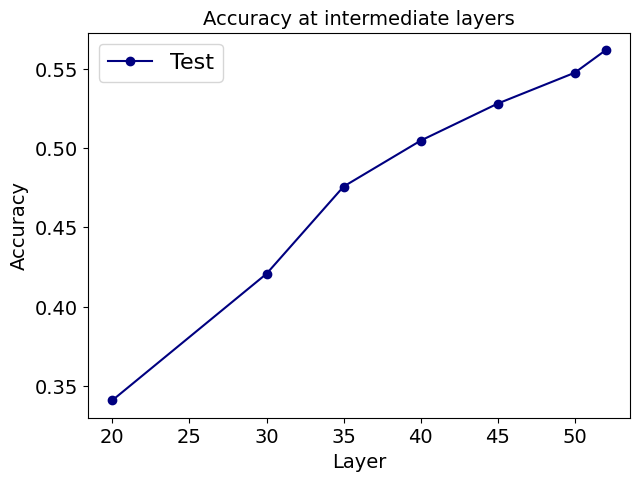

In [34]:
plt.figure(figsize=(7,5), dpi=100)
plt.title("Accuracy at intermediate layers",fontsize=14)
plt.plot(layers_to_use,test_acc_by_layer,marker="o",color="navy",label="Test")
plt.legend(fontsize=16)
plt.xlabel("Layer",fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Self-ensemble robustness evaluation

In [35]:
class WrappedCombinedModel(torch.nn.Module):

  def __init__(self, model):
    super(WrappedCombinedModel, self).__init__()
    self.model = model

  def forward(self, x):
    all_logits = self.model.model.predict_from_several_layers(x,[l-1 for l in [0, 1, 5, 10, 20,30,35,40,45,50,52][1:]])

    all_logits[54] = self.model.model.model(self.model.model.prepare_input(x)) # adding the prediction of the backbone itself

    all_logits = torch.stack([all_logits[l] for l in [20,30,35,40,45,50,52,54]],axis=1)

    all_logits = all_logits - torch.max(all_logits,axis=2,keepdims=True).values
    all_logits = all_logits - torch.max(all_logits,axis=1,keepdims=True).values

    logits = torch.topk(all_logits,3,axis=1).values[:,2]
    return logits

In [36]:
wrapped_combined_model = WrappedCombinedModel(linear_model)
wrapped_combined_model(
    torch.Tensor(np.zeros((1,3,32,32))).cuda()
).shape

torch.Size([1, 100])

In [37]:
test_hits,test_count,_ = eval_model(wrapped_combined_model, images_test_np, labels_test_np)
print(f"test={test_hits}/{test_count}={test_hits/test_count}")
self_ensemble_test_acc = test_hits / test_count

Eval: 100%|█████████████████████████████████████████████████████████| 79/79 [00:40<00:00,  1.95it/s]

test=5882/10000=0.5882


In [38]:
!pip install git+https://github.com/RobustBench/robustbench.git

  Cloning https://github.com/RobustBench/robustbench.git to /tmp/pip-req-build-1ditx_ny
  Running command git clone --filter=blob:none --quiet https://github.com/RobustBench/robustbench.git /tmp/pip-req-build-1ditx_ny
  Resolved https://github.com/RobustBench/robustbench.git to commit 776bc95bb4167827fb102a32ac5aea62e46cfaab
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fra31/auto-attack.git (to revision a39220048b3c9f2cca9a4d3a54604793c68eca7e) to /tmp/pip-install-jq92iytp/autoattack_2c1aac511be344f7a8482922c9895b8c
  Running command git clone --filter=blob:none --quiet https://github.com/fra31/auto-attack.git /tmp/pip-install-jq92iytp/autoattack_2c1aac511be344f7a8482922c9895b8c
  Running command git rev-parse -q --verify 'sha^a39220048b3c9f2cca9a4d3a54604793c68eca7e'
  Running command git fetch -q https://github.com/fra31/auto-attack.git a39220048b3c9f2cca9a4d3a54604793c68eca7e
  Resolved https://github.com/fra31/auto-attack.git to commit a39220048b3c9f2cca9a4

## Modified RobustBench AutoAttack method to accommodation randomness

Taking the code from the https://github.com/RobustBench/robustbench repository and modifying it slightly to easily accommodate the `rand` flag call

In [39]:
import warnings
from argparse import Namespace
from pathlib import Path
from typing import Callable, Dict, Optional, Sequence, Tuple, Union

import numpy as np
import pandas as pd
import torch
import random
from autoattack import AutoAttack
from autoattack.state import EvaluationState
from torch import nn
from tqdm import tqdm

from robustbench.data import CORRUPTIONS_DICT, get_preprocessing, load_clean_dataset, \
    CORRUPTION_DATASET_LOADERS
from robustbench.model_zoo.enums import BenchmarkDataset, ThreatModel
from robustbench.utils import clean_accuracy, load_model, parse_args, update_json
from robustbench.model_zoo import model_dicts as all_models


def benchmark(
    model: Union[nn.Module, Sequence[nn.Module]],
    n_examples: int = 10000,
    dataset: Union[str, BenchmarkDataset] = BenchmarkDataset.cifar_10,
    threat_model: Union[str, ThreatModel] = ThreatModel.Linf,
    to_disk: bool = False,
    model_name: Optional[str] = None,
    data_dir: str = "./data",
    corruptions_data_dir: Optional[str] = None,
    device: Optional[Union[torch.device, Sequence[torch.device]]] = None,
    batch_size: int = 32,
    eps: Optional[float] = None,
    log_path: Optional[str] = None,

    version='custom', #'rand', # 'rand' for models using stochasticity

    preprocessing: Optional[Union[str,
                                  Callable]] = None,
    aa_state_path: Optional[Path] = None,

    #stan's additional sections for explicitly choosing test set images to use
    id_start = None,
    id_stop = None,

    ) -> Tuple[float, float]:
    """Benchmarks the given model(s).

    It is possible to benchmark on 3 different threat models, and to save the results on disk. In
    the future benchmarking multiple models in parallel is going to be possible.

    :param model: The model to benchmark.
    :param n_examples: The number of examples to use to benchmark the model.
    :param dataset: The dataset to use to benchmark. Must be one of {cifar10, cifar100}
    :param threat_model: The threat model to use to benchmark, must be one of {L2, Linf
    corruptions}
    :param to_disk: Whether the results must be saved on disk as .json.
    :param model_name: The name of the model to use to save the results. Must be specified if
    to_json is True.
    :param data_dir: The directory where the dataset is or where the dataset must be downloaded.
    :param device: The device to run the computations.
    :param batch_size: The batch size to run the computations. The larger, the faster the
    evaluation.
    :param eps: The epsilon to use for L2 and Linf threat models. Must not be specified for
    corruptions threat model.
    :param preprocessing: The preprocessing that should be used for ImageNet benchmarking. Should be
    specified if `dataset` is `imageget`.
    :param aa_state_path: The path where the AA state will be saved and from where should be
    loaded if it already exists. If `None` no state will be used.

    :return: A Tuple with the clean accuracy and the accuracy in the given threat model.
    """
    if isinstance(model, Sequence) or isinstance(device, Sequence):
        # Multiple models evaluation in parallel not yet implemented
        raise NotImplementedError

    try:
        if model.training:
            warnings.warn(Warning("The given model is *not* in eval mode."))
    except AttributeError:
        warnings.warn(
            Warning(
                "It is not possible to asses if the model is in eval mode"))

    dataset_: BenchmarkDataset = BenchmarkDataset(dataset)
    threat_model_: ThreatModel = ThreatModel(threat_model)

    device = device or torch.device("cpu")
    model = model.to(device)

    prepr = get_preprocessing(dataset_, threat_model_, model_name,
                              preprocessing)

    clean_x_test, clean_y_test = load_clean_dataset(dataset_, n_examples,
                                                    data_dir, prepr)

    if id_start is not None and id_stop is not None:
      clean_x_test = clean_x_test[id_start:id_stop]
      clean_y_test = clean_y_test[id_start:id_stop]
      # taking a subset of the images
      print(f"using {len(clean_x_test)} images in the range {id_start} to {id_stop}")

    accuracy = clean_accuracy(model,
                              clean_x_test,
                              clean_y_test,
                              batch_size=batch_size,
                              device=device)
    print(f'Clean accuracy: {accuracy:.2%}')

    extra_metrics = {}  # dict to store corruptions_mce for corruptions threat models
    if threat_model_ in {ThreatModel.Linf, ThreatModel.L2}:
        if eps is None:
            raise ValueError(
                "If the threat model is L2 or Linf, `eps` must be specified.")

        adversary = AutoAttack(model,
                               norm=threat_model_.value,
                               eps=eps,
                               version=version,
                               device=device,
                               log_path=log_path,
                               attacks_to_run=['apgd-ce', 'apgd-t'] if version == "custom" else [], #Stan's addition
                               )
        x_adv = adversary.run_standard_evaluation(clean_x_test,
                                                  clean_y_test,
                                                  bs=batch_size,
                                                  state_path=aa_state_path)
        if aa_state_path is None:
            adv_accuracy = clean_accuracy(model,
                                        x_adv,
                                        clean_y_test,
                                        batch_size=batch_size,
                                        device=device)
        else:
            aa_state = EvaluationState.from_disk(aa_state_path)
            assert aa_state.robust_flags is not None
            adv_accuracy = aa_state.robust_flags.mean().item()

    elif threat_model_ in [ThreatModel.corruptions, ThreatModel.corruptions_3d]:
        corruptions = CORRUPTIONS_DICT[dataset_][threat_model_]
        print(f"Evaluating over {len(corruptions)} corruptions")
        # Exceptionally, for corruptions (2d and 3d) we use only resizing to 224x224
        prepr = get_preprocessing(dataset_, threat_model_, model_name,
                                  'Res224')
        # Save into a dict to make a Pandas DF with nested index
        corruptions_data_dir = corruptions_data_dir or data_dir
        adv_accuracy, adv_mce = corruptions_evaluation(
            batch_size, corruptions_data_dir, dataset_, threat_model_,
            device, model, n_examples, to_disk, prepr, model_name)

        extra_metrics['corruptions_mce'] = adv_mce
    else:
        raise NotImplementedError
    print(f'Adversarial accuracy: {adv_accuracy:.2%}')

    if to_disk:
        if model_name is None:
            raise ValueError(
                "If `to_disk` is True, `model_name` should be specified.")

        update_json(dataset_, threat_model_, model_name, accuracy,
                    adv_accuracy, eps, extra_metrics)

    data = (clean_x_test, clean_y_test, x_adv)
    return accuracy, adv_accuracy, data


## Adversarial accuracy evaluation (16 min to eval on 32 test images)

You should get something like ~45% adversarial accuracy. The SOTA is 42.67% as of October 2024 and with tons of adversarial training on top! Congrats!

In [40]:
device = torch.device("cuda:0")

print(f"Self-ensemble test acc = {self_ensemble_test_acc}")
print("\n---------------------------------------------\n")

t1 = time.time()

with isolated_environment():
  clean_acc, robust_acc, data_out = benchmark(wrapped_combined_model.eval(),
                                    dataset=f'cifar{classes}',
                                    threat_model='Linf',
                                    device=device,
                                    eps=8/255,
                                    n_examples=32, #32 images to have it done quick
                                    version='rand',
                                    batch_size=32)

t2 = time.time()
print(f"Time taken = {int(t2-t1)} seconds")

Self-ensemble test acc = 0.5882

---------------------------------------------

Files already downloaded and verified
Clean accuracy: 68.75%
setting parameters for rand version
using rand version including apgd-ce, apgd-dlr.



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/autoattack/checks.py", line 100, in check_dynamic
    sys.settrace(tracefunc)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/local/lib/python3.10/dist-packages/autoattack/checks.py", line 102, in check_dynamic
    sys.settrace(None)



initial accuracy: 65.62%
apgd-ce - 1/1 - 6 out of 21 successfully perturbed
robust accuracy after APGD-CE: 46.88% (total time 491.7 s)
apgd-dlr - 1/1 - 1 out of 15 successfully perturbed
robust accuracy after APGD-DLR: 43.75% (total time 888.4 s)
max Linf perturbation: 0.03137, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 43.75%
Adversarial accuracy: 62.50%
Time taken = 890 seconds


## Visualizing successful attacks

In [41]:
def cifar100_class_to_description(class_num):
    classes = [
        "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle",
        "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
        "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock",
        "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
        "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
        "house", "kangaroo", "keyboard", "lamp", "lawn mower", "leopard", "lion",
        "lizard", "lobster", "man", "maple tree", "motorcycle", "mountain", "mouse",
        "mushroom", "oak tree", "orange", "orchid", "otter", "palm tree", "pear",
        "pickup truck", "pine tree", "plain", "plate", "poppy", "porcupine",
        "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea",
        "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
        "squirrel", "streetcar", "sunflower", "sweet pepper", "table", "tank",
        "telephone", "television", "tiger", "tractor", "train", "trout", "tulip",
        "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"
    ]

    if 0 <= class_num < len(classes):
        return classes[class_num]
    else:
        return "Invalid class number"

In [42]:
from collections import Counter

def count_and_sort_frequencies(lst):
    # Count occurrences of each number
    counter = Counter(lst)

    # Sort items by frequency in descending order
    sorted_items = counter.most_common()

    # Print the sorted items
    for number, frequency in sorted_items:
        print(f"{number}: {frequency}")

torch.Size([32, 3, 32, 32])
torch.Size([32])
torch.Size([32, 3, 32, 32])


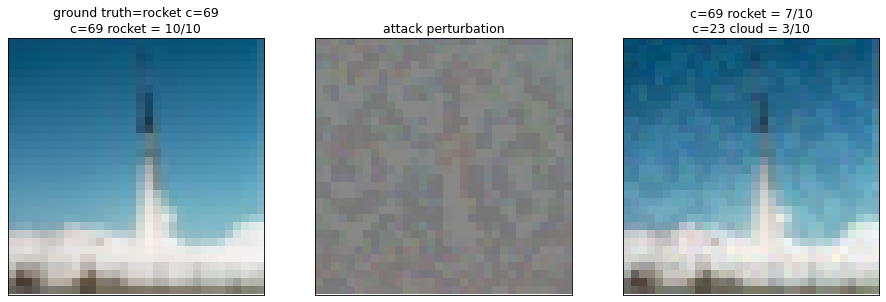

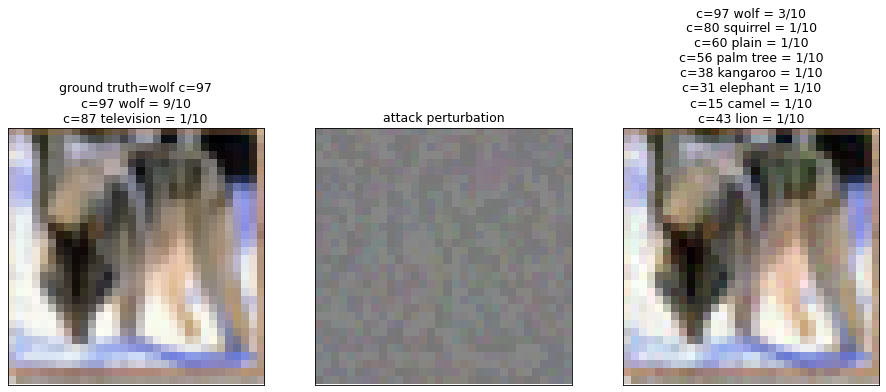

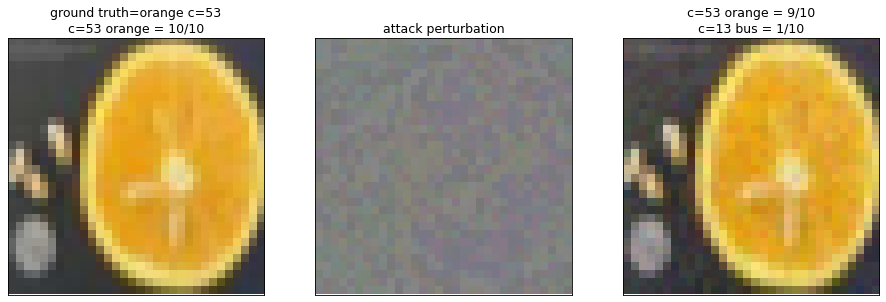

In [43]:
reps = 10

for (clean_xs, clean_ys, adv_xs) in [data_out]:

  clean_xs = clean_xs.cuda()
  clean_ys = clean_ys.cuda()
  adv_xs = adv_xs.cuda()

  print(clean_xs.shape)
  print(clean_ys.shape)
  print(adv_xs.shape)

  all_clean_pred_argmaxes = []
  for r in range(reps):
    with torch.no_grad():
      logits = wrapped_combined_model(clean_xs).detach().cpu().numpy()
    pred_argmaxes = np.argmax(logits,axis=-1)
    all_clean_pred_argmaxes.append(pred_argmaxes)

  all_pred_argmaxes = []
  for r in range(reps):
    with torch.no_grad():
      logits = wrapped_combined_model(adv_xs).detach().cpu().numpy()
    pred_argmaxes = np.argmax(logits,axis=-1)
    all_pred_argmaxes.append(pred_argmaxes)

  for i in range(len(clean_xs)):
    if np.sum(clean_xs[i].detach().cpu().numpy() - adv_xs[i].detach().cpu().numpy()) > 0:

      plt.figure(figsize = (3*5,5), dpi=75)

      plt.subplot(1,3,1)
      vals = [pred_argmaxes[i] for pred_argmaxes in all_clean_pred_argmaxes]
      vals_sorted, freqs_sorted = zip(*Counter(vals).most_common())
      plt.xticks([],[])
      plt.yticks([],[])

      title = f"ground truth={cifar100_class_to_description(clean_ys[i])} c={clean_ys[i]}\n"
      for j in range(len(vals_sorted)):
        title = title + f"c={vals_sorted[j]} {cifar100_class_to_description(vals_sorted[j]) } = {freqs_sorted[j]}/{reps}\n"
      plt.title(title[:-1])

      plt.imshow(adv_xs[i].detach().cpu().numpy().transpose([1,2,0]))

      plt.imshow(clean_xs[i].detach().cpu().numpy().transpose([1,2,0]))

      plt.subplot(1,3,3)
      vals = [pred_argmaxes[i] for pred_argmaxes in all_pred_argmaxes]
      vals_sorted, freqs_sorted = zip(*Counter(vals).most_common())
      plt.xticks([],[])
      plt.yticks([],[])

      title = ""
      for j in range(len(vals_sorted)):
        title = title + f"c={vals_sorted[j]} {cifar100_class_to_description(vals_sorted[j]) } = {freqs_sorted[j]}/{reps}\n"
      plt.title(title[:-1])

      plt.imshow(adv_xs[i].detach().cpu().numpy().transpose([1,2,0]))

      plt.subplot(1,3,2)
      plt.title("attack perturbation")
      plt.imshow(0.5+clean_xs[i].detach().cpu().numpy().transpose([1,2,0]) - adv_xs[i].detach().cpu().numpy().transpose([1,2,0]))
      plt.xticks([],[])
      plt.yticks([],[])

      plt.show()

# Visualizing all classes starting from a uniform grey picture

In [44]:
def random_class_without_list(excluded_lists, classes=classes):
  available_classes = [[c for c in range(classes) if c not in excluded_lists[i]] for i in range(len(excluded_lists))]
  return [np.random.choice(cs) for cs in available_classes]

def hard_to_soft_targets(hard_targets,num_classes=classes):
  target_labels_hard = torch.Tensor(hard_targets).to(torch.long)
  target_labels_soft = torch.nn.functional.one_hot(target_labels_hard, num_classes=num_classes).to(torch.float).to("cuda")
  return target_labels_soft.detach().cpu().numpy()

hard_to_soft_targets([0,0,2],num_classes=3)

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [45]:
import torch.optim as optim

'''
How to specificy attacks:

adversarial_attack_specification = [
    (model, images, perturbation_ids, soft_targets),
    (model, images, perturbation_ids, soft_targets),
    (model, images, perturbation_ids, soft_targets),
    (model, images, perturbation_ids, soft_targets),
]
'''

def get_complex_specification_adversaries(
    attack_specifications,
    batch_size=32,
    lr=1e-1,
    optimizer_in=optim.SGD,
    attack_resolution=32,
    clip_images = True,
    steps=100,
    attack_Linfty_limit = None,
    stop_at_loss = None,
    verbose = True,
    flip_loss_sign = False,
  ):

  collect_images = []

  attack_specifications_prepared = []
  for (model, images, perturbation_ids, soft_targets) in attack_specifications:
    attack_specifications_prepared.append(
        (model.to("cuda"),torch.Tensor(images).to("cuda"),perturbation_ids,torch.Tensor(soft_targets).to("cuda"))
        )

  # count how many perturbations are needed
  perturbation_count = max([max(specification[2]) for specification in attack_specifications]) + 1

  # perturbations
  image_perturbations = torch.Tensor(np.zeros((perturbation_count,3,attack_resolution,attack_resolution))).to("cuda")
  image_perturbations.requires_grad = True

  optimizer = optimizer_in([image_perturbations],lr=lr)

  if verbose:
    steps_bar = tqdm(range(steps), desc='Adversary progress', ncols=100)
  else:
    steps_bar = range(steps)

  for step in steps_bar:

    losses = []

    for (model, images, perturbation_ids, soft_targets) in attack_specifications_prepared:
      perturbations_to_use = image_perturbations[perturbation_ids]

      if attack_Linfty_limit is None:
        attacked_images = images + perturbations_to_use
      else:
        attacked_images = images + attack_Linfty_limit*torch.tanh(perturbations_to_use)

      if clip_images:
        attacked_images = torch.clip(attacked_images,0,1)

      #batching for the model
      batched_losses = []
      iterations = int(np.ceil(attacked_images.shape[0]/batch_size))
      for it in range(iterations):
        i1 = it*batch_size
        i2 = min([(it+1)*batch_size,attacked_images.shape[0]])
        logits = model(attacked_images[i1:i2])
        loss = torch.nn.functional.cross_entropy(logits, soft_targets[i1:i2],reduction="none")
        batched_losses.append(loss)

      if flip_loss_sign is False:
        torch.mean(torch.concatenate(batched_losses,axis=0)).backward()
      else:
        torch.mean(-torch.concatenate(batched_losses,axis=0)).backward()

      losses.append(torch.concatenate(batched_losses,axis=0).detach().cpu().numpy())

    overall_loss = np.mean(np.stack(losses))

    if verbose:
      steps_bar.set_description(f"loss = {overall_loss}")

    if stop_at_loss is not None and ((overall_loss <= stop_at_loss and flip_loss_sign is False) or (overall_loss >= stop_at_loss and flip_loss_sign is True)):
      # getting the resulting images
      if attack_Linfty_limit is None:
        return image_perturbations.detach().cpu().numpy()
      else:
        return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy()


    optimizer.step()
    optimizer.zero_grad()

    collect_images.append(
      attacked_images
    )

  # getting the resulting images
  if attack_Linfty_limit is None:
    return image_perturbations.detach().cpu().numpy(), collect_images
  else:
    return attack_Linfty_limit*torch.tanh(image_perturbations).detach().cpu().numpy(), collect_images




## 4 samples for each of the 100 classes of CIFAR-100

In [46]:
# using just the multi-resolution backbone, that's enough for pretty pictures!

wrapped_model_to_use = ImportedModelWrapper(backbone_model.model, make_multichannel_input).to("cuda")
wrapped_model_to_use.multichannel_fn = make_multichannel_input

In [47]:
model_to_use = wrapped_model_to_use

per_class_reps = 5
classes_at_once = 4

all_perturbed_images = []

for i in range(25):
  target_labels = []
  for c in range(i*classes_at_once,(i+1)*classes_at_once):
    target_labels += [c]*per_class_reps

  print(f"---- classes={target_labels} ----")

  size = 128
  j = 0

  count = 20
  batch_size = 10

  images_selected = images_test_np[j*count:(j+1)*count]
  images_selected = images_test_np[labels_test_np == 8][:count]

  images_selected = np.ones(images_selected.shape)*0.5 #+ np.random.rand(*images_selected.shape)*0.05

  model_to_use = model_to_use.eval()

  attack_specifications = [
      (
        model_to_use.eval(),
        images_selected.transpose([0,3,1,2]), #all of the train set
        range(len(images_selected)), #different perturbation id for each image = an attack per image
        hard_to_soft_targets(target_labels), #randomly selected target labels exluding the original label of the image
      ), # a single model to attack with its specification
  ]

  perturbations, _ = get_complex_specification_adversaries(
      attack_specifications,
      steps=400,
      batch_size=batch_size, #if you have cude problems, you can decrease this => less memory but slower
      attack_Linfty_limit=size/255,
      lr=10e-1,#2e-1,#*6,#1e0 if layer < 5 else 1e-1,
      stop_at_loss=1e-2,
  )

  perturbed_images = np.clip(images_selected + perturbations.transpose([0,2,3,1]),0,1)
  all_perturbed_images.append(perturbed_images)

---- classes=[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3] ----


loss = 0.24522440135478973: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.11it/s]


---- classes=[4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7] ----


loss = 0.10840459913015366: 100%|█████████████████████████████████| 400/400 [01:19<00:00,  5.01it/s]


---- classes=[8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11] ----


loss = 0.07019796222448349: 100%|█████████████████████████████████| 400/400 [01:20<00:00,  4.95it/s]


---- classes=[12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15] ----


loss = 0.08402121812105179: 100%|█████████████████████████████████| 400/400 [01:20<00:00,  4.96it/s]


---- classes=[16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19] ----


loss = 0.06240381672978401: 100%|█████████████████████████████████| 400/400 [01:19<00:00,  5.03it/s]


---- classes=[20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23] ----


loss = 0.07364842295646667: 100%|█████████████████████████████████| 400/400 [01:19<00:00,  5.05it/s]


---- classes=[24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27] ----


loss = 0.0954054519534111: 100%|██████████████████████████████████| 400/400 [01:19<00:00,  5.06it/s]


---- classes=[28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31] ----


loss = 0.03436213731765747: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.07it/s]


---- classes=[32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35] ----


loss = 0.1504121869802475: 100%|██████████████████████████████████| 400/400 [01:18<00:00,  5.10it/s]


---- classes=[36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 39, 39] ----


loss = 0.059947527945041656: 100%|████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43] ----


loss = 0.14676454663276672: 100%|█████████████████████████████████| 400/400 [01:19<00:00,  5.04it/s]


---- classes=[44, 44, 44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46, 46, 46, 47, 47, 47, 47, 47] ----


loss = 0.23312735557556152: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[48, 48, 48, 48, 48, 49, 49, 49, 49, 49, 50, 50, 50, 50, 50, 51, 51, 51, 51, 51] ----


loss = 0.055706094950437546: 100%|████████████████████████████████| 400/400 [01:18<00:00,  5.09it/s]


---- classes=[52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55] ----


loss = 0.20799846947193146: 100%|█████████████████████████████████| 400/400 [01:19<00:00,  5.06it/s]


---- classes=[56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59] ----


loss = 0.02155473828315735: 100%|█████████████████████████████████| 400/400 [01:20<00:00,  4.96it/s]


---- classes=[60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63] ----


loss = 0.1890510469675064: 100%|██████████████████████████████████| 400/400 [01:19<00:00,  5.02it/s]


---- classes=[64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67] ----


loss = 0.13908900320529938: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71] ----


loss = 0.31689053773880005: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75] ----


loss = 0.2154138833284378: 100%|██████████████████████████████████| 400/400 [01:19<00:00,  5.06it/s]


---- classes=[76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79] ----


loss = 0.13472440838813782: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83] ----


loss = 0.05495581775903702: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.07it/s]


---- classes=[84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87] ----


loss = 0.041689179837703705: 100%|████████████████████████████████| 400/400 [01:18<00:00,  5.07it/s]


---- classes=[88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91] ----


loss = 0.06026320531964302: 100%|█████████████████████████████████| 400/400 [01:18<00:00,  5.07it/s]


---- classes=[92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 95, 95, 95, 95, 95] ----


loss = 0.1512589007616043: 100%|██████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


---- classes=[96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99] ----


loss = 0.2983644902706146: 100%|██████████████████████████████████| 400/400 [01:18<00:00,  5.08it/s]


In [48]:
all_composite_images = []

for i in range(25):
  for j in range(4):

    cut = all_perturbed_images[i][j*5:j*5+4]
    composite_image = np.zeros((2*32,2*32,3))
    composite_image[:32,:32,:] = cut[0]
    composite_image[:32,32:64,:] = cut[1]
    composite_image[32:64,:32,:] = cut[2]
    composite_image[32:64,32:64,:] = cut[3]

    composite_image[:,32,:] = 1
    composite_image[32,:,:] = 1

    all_composite_images.append(composite_image)

    # plt.imshow(composite_image)
    # plt.show()

In [49]:
def cifar100_class_to_description(class_num):
    classes = [
        "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle",
        "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
        "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock",
        "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
        "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
        "house", "kangaroo", "keyboard", "lamp", "lawn mower", "leopard", "lion",
        "lizard", "lobster", "man", "maple tree", "motorcycle", "mountain", "mouse",
        "mushroom", "oak tree", "orange", "orchid", "otter", "palm tree", "pear",
        "pickup truck", "pine tree", "plain", "plate", "poppy", "porcupine",
        "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea",
        "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
        "squirrel", "streetcar", "sunflower", "sweet pepper", "table", "tank",
        "telephone", "television", "tiger", "tractor", "train", "trout", "tulip",
        "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"
    ]

    if 0 <= class_num < len(classes):
        return classes[class_num]
    else:
        return "Invalid class number"

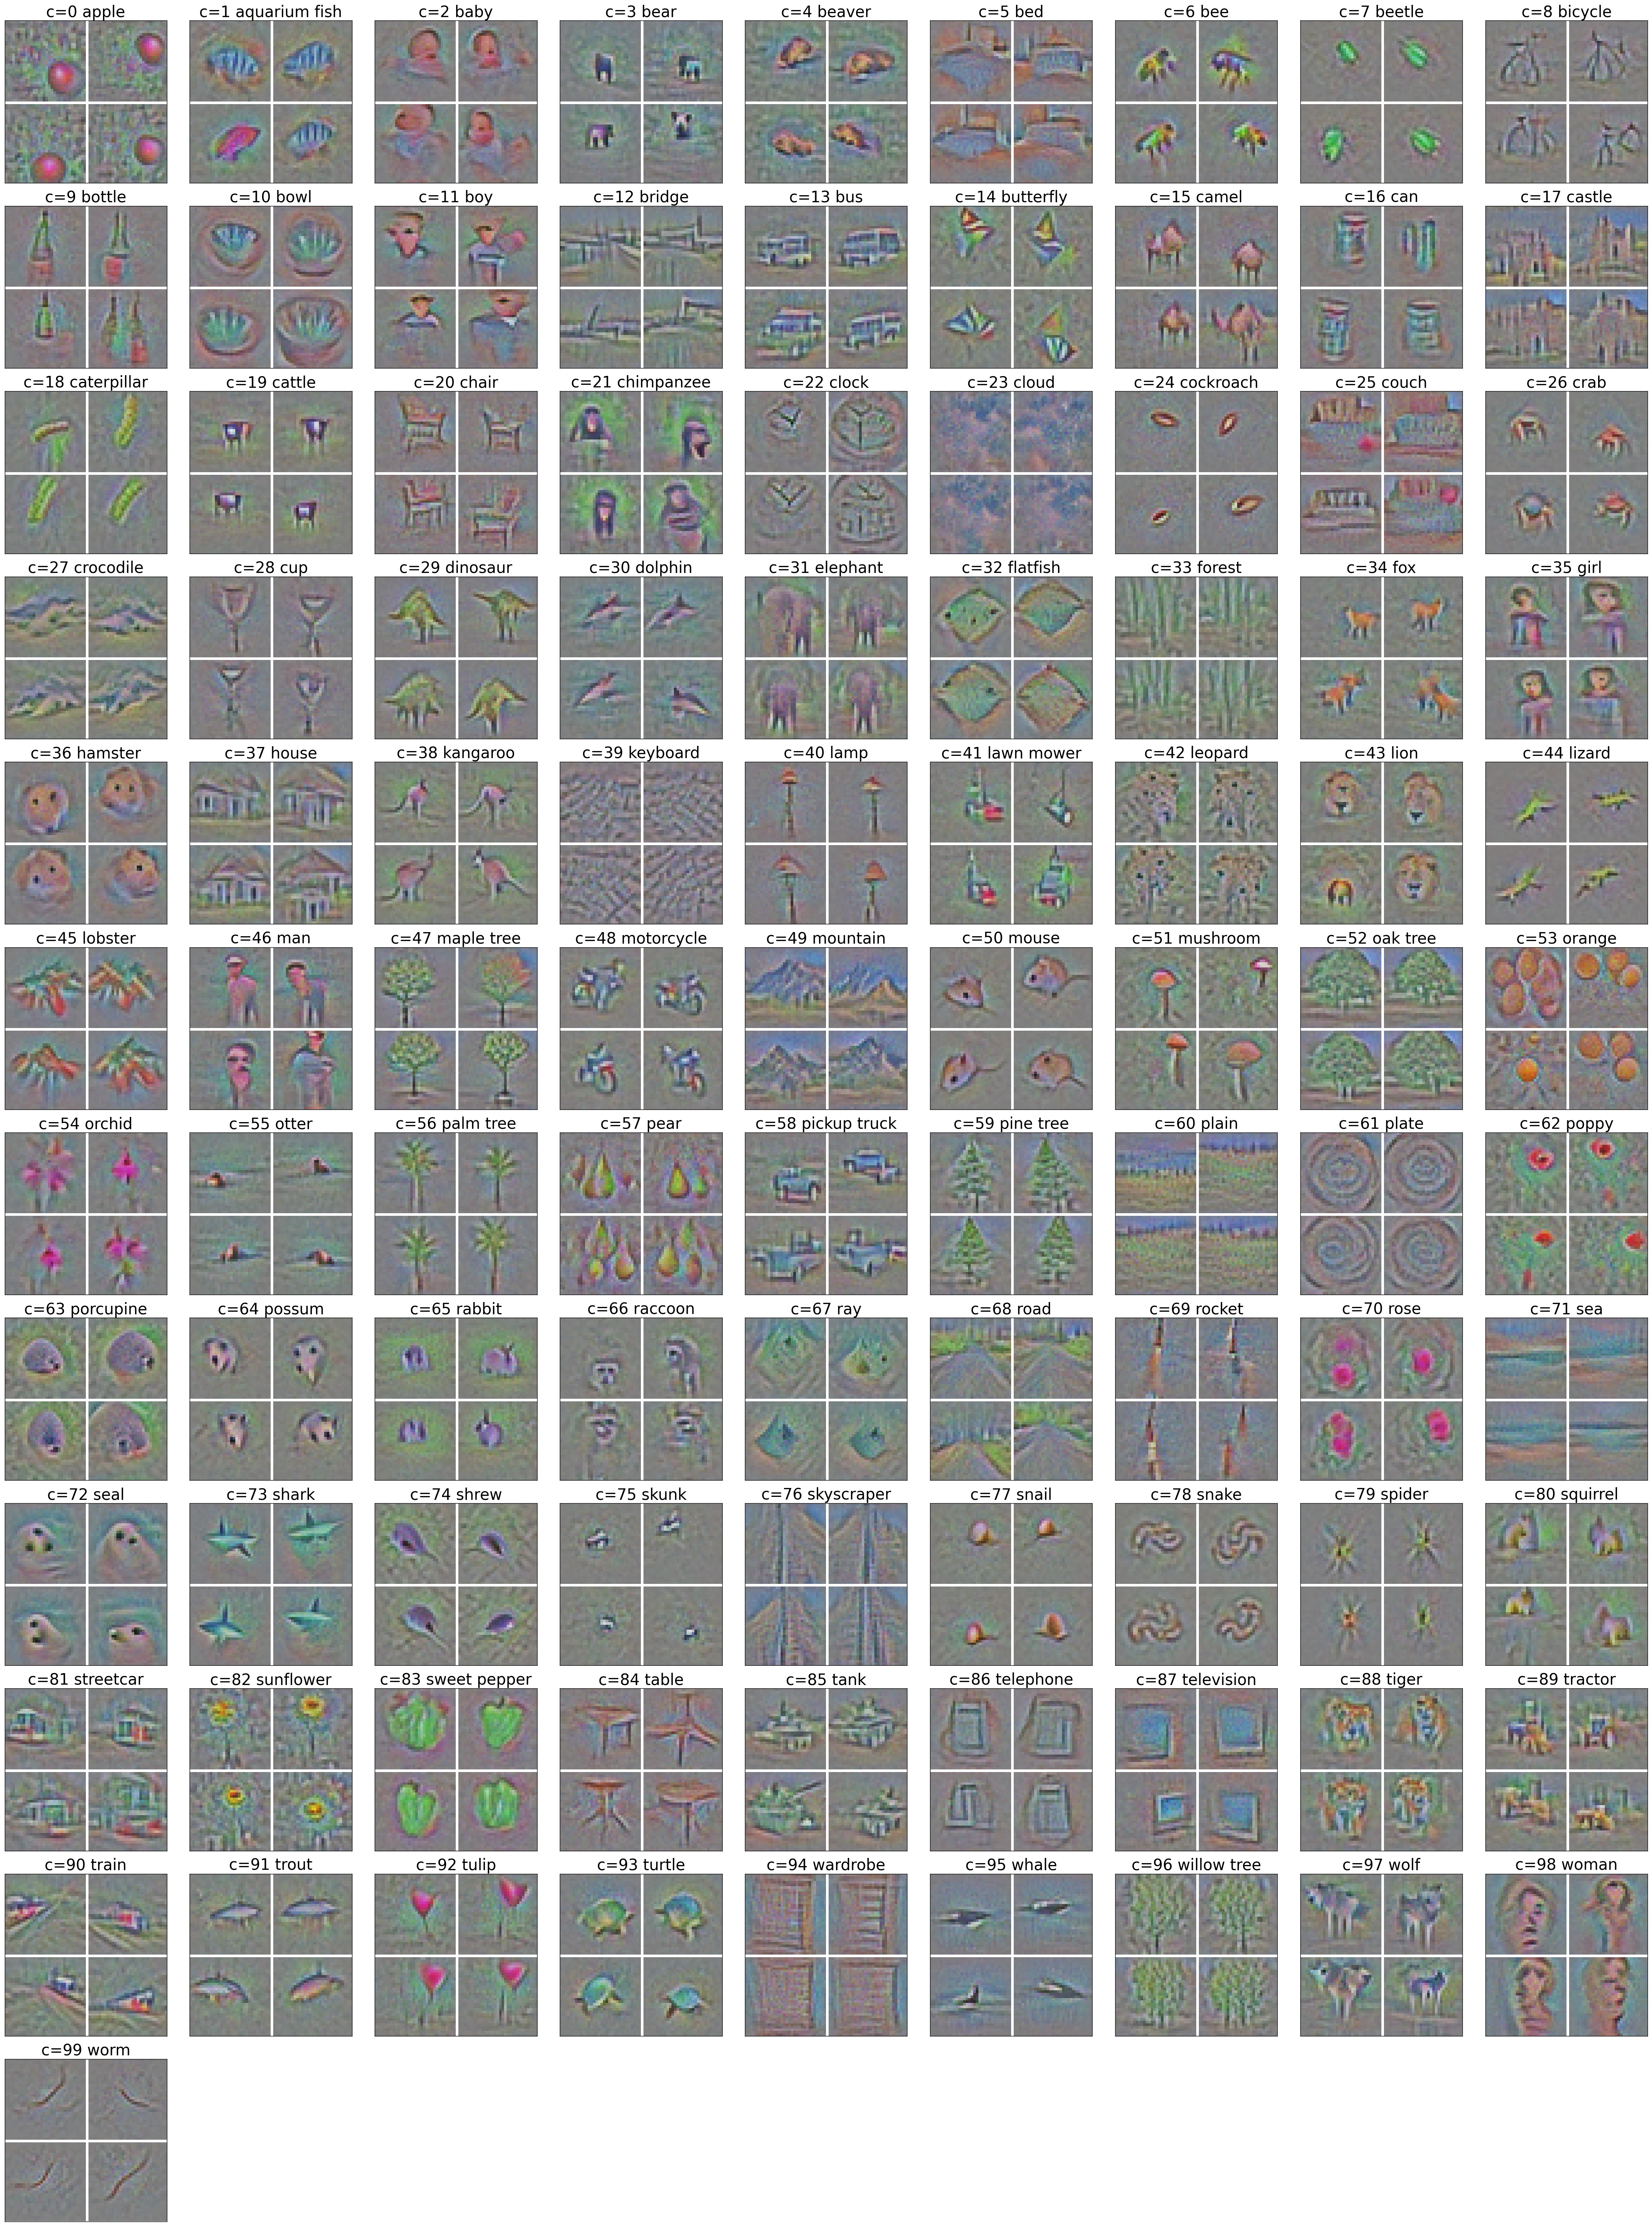

In [50]:
plt.figure(figsize=(4*9,4*12),dpi=125)
for i in range(100):
  plt.subplot(12,9,i+1)
  plt.title(f"c={i} {cifar100_class_to_description(i)}",fontsize=24)
  plt.imshow(all_composite_images[i])
  plt.xticks([],[])
  plt.yticks([],[])
plt.tight_layout()

plt.show()